In [1]:
!pip install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight

  Cloning git://github.com/alok-ai-lab/DeepInsight.git to /tmp/pip-install-yig4v6e9/deepinsight_0b57b925a36d4e779b96146819092179
  Running command git clone -q git://github.com/alok-ai-lab/DeepInsight.git /tmp/pip-install-yig4v6e9/deepinsight_0b57b925a36d4e779b96146819092179
  Created wheel for DeepInsight: filename=DeepInsight-0.1.0-py3-none-any.whl size=17216 sha256=66e30fbec1950fd8710bf118ad8432d0ca833009767920db36c1539e0da2a8a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-pitel8wf/wheels/e4/bc/9d/c483e2a4902573f36c6a2a2e90e247662dada37685d34c1a58
Successfully built DeepInsight


## Load packages

In [30]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Load the SDN traffic dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/SDN/sdn_traffic_dataset.csv')
df.shape

(104345, 23)

In [5]:
df.sample(6)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
252,11485,1,10.0.0.2,10.0.0.8,117399,125147334,260,750000000,2.610000e+11,3,1943,13533,14426178,451,0,UDP,1,4047,143926620,0,0.0,0.0,0
976,9966,1,10.0.0.1,10.0.0.7,59972,63930152,133,252000000,1.330000e+11,2,1931,13532,14425112,451,0,UDP,3,3413,3539,0,0.0,0.0,0
833,11335,1,10.0.0.2,10.0.0.8,49807,53094262,110,739000000,1.110000e+11,3,1790,13525,14417650,450,0,UDP,1,3753,1242,0,0.0,0.0,0
462,9846,1,10.0.0.1,10.0.0.7,6002,6398132,13,242000000,1.324200e+10,2,1910,0,0,0,0,UDP,4,3381,98996058,0,6384.0,6384.0,1
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
681,9876,1,10.0.0.1,10.0.0.7,19529,20817914,43,245000000,4.324500e+10,2,1910,13527,14419782,450,0,UDP,1,3582,1332,0,0.0,0.0,0


In [6]:
df.isna().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [7]:
set(df['rx_kbps'])

{0.0,
 1149.0,
 1155.0,
 1282.0,
 1393.0,
 1725.0,
 1796.0,
 2354.0,
 2358.0,
 2452.0,
 2561.0,
 2562.0,
 2564.0,
 2565.0,
 2566.0,
 2567.0,
 2568.0,
 2571.0,
 2575.0,
 2577.0,
 2580.0,
 2581.0,
 2587.0,
 2588.0,
 2591.0,
 2594.0,
 2603.0,
 2607.0,
 2615.0,
 2619.0,
 2676.0,
 3752.0,
 3837.0,
 3838.0,
 3839.0,
 3840.0,
 3917.0,
 4811.0,
 4993.0,
 5232.0,
 5563.0,
 5564.0,
 5880.0,
 6307.0,
 6384.0,
 6400.0,
 6430.0,
 6446.0,
 6451.0,
 6454.0,
 6456.0,
 6457.0,
 6459.0,
 6464.0,
 6466.0,
 6467.0,
 6501.0,
 6502.0,
 6515.0,
 7165.0,
 7555.0,
 7673.0,
 7674.0,
 7676.0,
 7678.0,
 7756.0,
 8969.0,
 9018.0,
 9473.0,
 9721.0,
 9722.0,
 10120.0,
 10240.0,
 10242.0,
 10243.0,
 10271.0,
 10288.0,
 10289.0,
 10303.0,
 11699.0,
 12817.0,
 12818.0,
 12831.0,
 14134.0,
 15931.0,
 16577.0}

In [8]:
df.dropna(inplace=True)
df.isna().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [9]:
df.shape

(1000, 23)

In [10]:
df.Protocol.unique()

array(['UDP'], dtype=object)

In [11]:
bin = {'UDP':0, 
       'TCP':2, 
       'ICMP':3
       }
# apply using map
df['Protocol'] = df.Protocol.map(bin)

In [12]:
dataset = df.values
dataset

array([[11425, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [11605, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [11425, 1, '10.0.0.2', ..., 0.0, 0.0, 0],
       ...,
       [9966, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [9966, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [9936, 1, '10.0.0.1', ..., 0.0, 0.0, 0]], dtype=object)

## Split into input X and output Y variables

In [13]:
X = dataset[:,4:22].astype(float)
Y = dataset[:,22]

In [14]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## Define the model

In [15]:
def model():
	# create model
	model = Sequential()
	model.add(Dense(18, input_dim=18, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

## Define a basic classifier

In [16]:
estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5)

In [17]:
estimator.fit(X, encoded_Y)

Epoch 1/100
200/200 [==============================] - 1s 890us/step - loss: 3667282688.0000 - accuracy: 0.8150
Epoch 2/100
200/200 [==============================] - 0s 958us/step - loss: 71983920.0000 - accuracy: 0.7210
Epoch 3/100
200/200 [==============================] - 0s 979us/step - loss: 34892968.0000 - accuracy: 0.7420
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 52549400.0000 - accuracy: 0.7250
Epoch 5/100
200/200 [==============================] - 0s 914us/step - loss: 59556196.0000 - accuracy: 0.7250
Epoch 6/100
200/200 [==============================] - 0s 901us/step - loss: 43186176.0000 - accuracy: 0.7360
Epoch 7/100
200/200 [==============================] - 0s 910us/step - loss: 45177320.0000 - accuracy: 0.7350
Epoch 8/100
200/200 [==============================] - 0s 880us/step - loss: 63487896.0000 - accuracy: 0.7400
Epoch 9/100
200/200 [==============================] - 0s 880us/step - loss: 65655848.0000 - accuracy: 0.7210
Epoch 10/1

In [18]:
estimator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                342       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 19        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


## Evaluate the model with cross validation

In [20]:
estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
180/180 [==============================] - 0s 955us/step - loss: 9483329536.0000 - accuracy: 0.2667
Epoch 2/100
180/180 [==============================] - 0s 965us/step - loss: 28592158.0000 - accuracy: 0.7622
Epoch 3/100
180/180 [==============================] - 0s 924us/step - loss: 20854580.0000 - accuracy: 0.7956
Epoch 4/100
180/180 [==============================] - 0s 965us/step - loss: 20287052.0000 - accuracy: 0.8044
Epoch 5/100
180/180 [==============================] - 0s 930us/step - loss: 21644566.0000 - accuracy: 0.7822
Epoch 6/100
180/180 [==============================] - 0s 915us/step - loss: 26268500.0000 - accuracy: 0.7678
Epoch 7/100
180/180 [==============================] - 0s 960us/step - loss: 17185812.0000 - accuracy: 0.7756
Epoch 8/100
180/180 [==============================] - 0s 922us/step - loss: 27967080.0000 - accuracy: 0.7844
Epoch 9/100
180/180 [==============================] - 0s 976us/step - loss: 20457006.0000 - accuracy: 0.7756
Epoch 10

## Evaluate baseline model with a standardized dataset

In [21]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model, epochs=100, batch_size=5)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
180/180 [==============================] - 0s 933us/step - loss: 0.4601 - accuracy: 0.8544
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 0.1488 - accuracy: 0.9967
Epoch 3/100
180/180 [==============================] - 0s 942us/step - loss: 0.0577 - accuracy: 1.0000
Epoch 4/100
180/180 [==============================] - 0s 915us/step - loss: 0.0279 - accuracy: 1.0000
Epoch 5/100
180/180 [==============================] - 0s 945us/step - loss: 0.0158 - accuracy: 1.0000
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 7/100
180/180 [==============================] - 0s 907us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 8/100
180/180 [==============================] - 0s 992us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 9/100
180/180 [==============================] - 0s 873us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 10/100
180/180 [==============================] - 0s 895us/step - loss:

### Using **DeepInsight** to transform our data to a matrix format for a **Convolutional Neural Network architecture**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)

In [32]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [35]:
it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

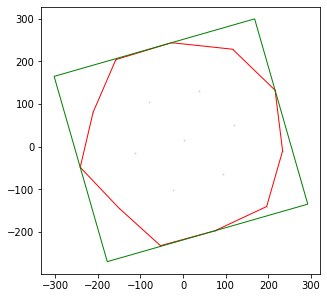

In [36]:
plt.figure(figsize=(5, 5))
it.fit(X_train_norm, plot=True)

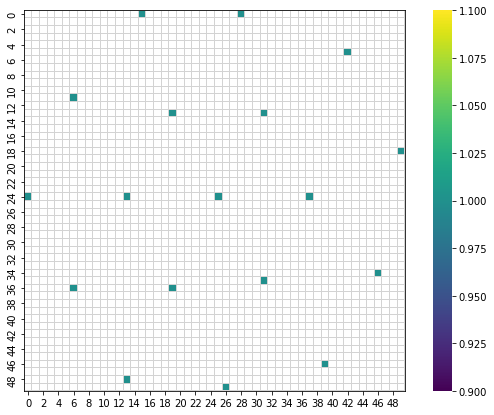

In [37]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
for _, spine in ax.spines.items():
    spine.set_visible(True)

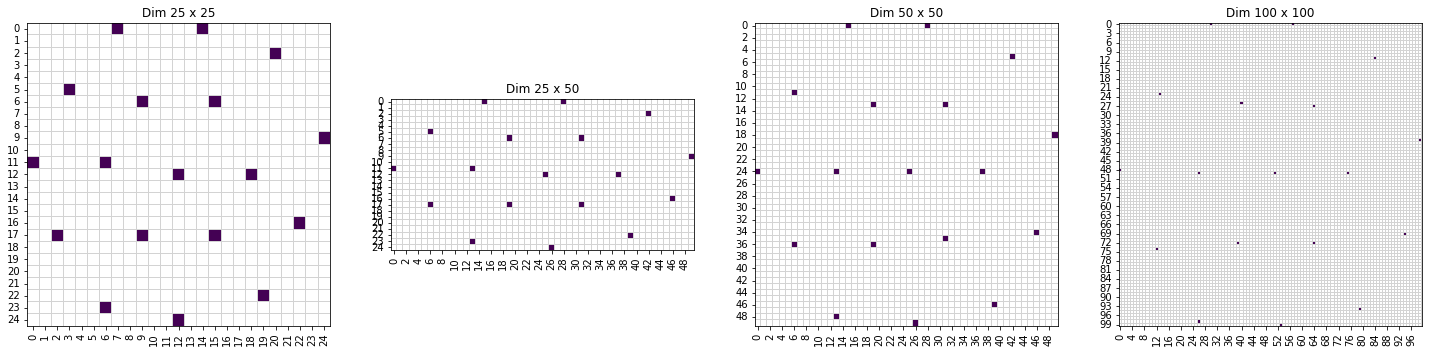

In [38]:
px_sizes = [25, (25, 50), 50, 100]

fig, ax = plt.subplots(1, len(px_sizes), figsize=(25, 7))
for ix, px in enumerate(px_sizes):
    it.pixels = px
    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan
    cax = sns.heatmap(fdm, cmap="viridis", linewidth=0.01, 
                      linecolor="lightgrey", square=True, 
                      ax=ax[ix], cbar=False)
    cax.set_title('Dim {} x {}'.format(*it.pixels))
    for _, spine in cax.spines.items():
        spine.set_visible(True)

it.pixels = 50

In [39]:
mat_train = it.transform(X_train_norm)
mat_test = it.transform(X_test_norm)

In [40]:
mat_train = it.fit_transform(X_train_norm)
mat_test = it.fit_transform(X_test_norm)

In [41]:
mat_train = np.asarray(mat_train).astype('float32')
mat_test = np.asarray(mat_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [42]:
mat_train.shape

(800, 50, 50, 3)

## Train a CNN Model

In [67]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(50, 50, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [68]:
cnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 50)        1400      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        28864     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 64)          36928     
Total params: 67,192
Trainable params: 67,192
Non-trainable params: 0
_________________________________________________________________


In [69]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [70]:
cnn_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 50)        1400      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 64)        28864     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)              

In [71]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = cnn_model.fit(mat_train, y_train, epochs=30, validation_data=(mat_test, y_test))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


25/25 [==============================] - 3s 118ms/step - loss: 0.5000 - accuracy: 0.8213 - val_loss: 0.4278 - val_accuracy: 0.8400
Epoch 2/30
25/25 [==============================] - 3s 113ms/step - loss: 0.4325 - accuracy: 0.8400 - val_loss: 0.4042 - val_accuracy: 0.8400
Epoch 3/30
25/25 [==============================] - 3s 114ms/step - loss: 0.3913 - accuracy: 0.8400 - val_loss: 0.3294 - val_accuracy: 0.8400
Epoch 4/30
25/25 [==============================] - 3s 113ms/step - loss: 0.3269 - accuracy: 0.8788 - val_loss: 0.2770 - val_accuracy: 0.9350
Epoch 5/30
25/25 [==============================] - 3s 113ms/step - loss: 0.2863 - accuracy: 0.9162 - val_loss: 0.2525 - val_accuracy: 0.9350
Epoch 6/30
25/25 [==============================] - 3s 113ms/step - loss: 0.2444 - accuracy: 0.9162 - val_loss: 0.2093 - val_accuracy: 0.9350
Epoch 7/30
25/25 [==============================] - 3s 113ms/step - loss: 0.2265 - accuracy: 0.9175 - val_loss: 0.1760 - val_accuracy: 0.9350
Epoch 8/30
25/25 